In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext blackcellmagic

In [2]:
import sys
sys.path.append("../../")
import torchvision
import os
import torch
import time
from pathlib import Path
from PIL import Image
import numpy as np
import cv2
import torchvision
import xml.etree.ElementTree as ET
from random import randrange

from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from matplotlib import pyplot as plt

from utils_cv.common.data import unzip_url, data_path
from utils_cv.detection.data import Urls
from utils_cv.detection.plot import display_bounding_boxes
from utils_cv.detection.model import get_bounding_boxes, get_transform
from utils_cv.detection.references.engine import train_one_epoch, evaluate
from utils_cv.detection.references.utils import collate_fn

### Load data

In [3]:
class FridgeObjectsDataset(object):
    def __init__(self, root, transforms):
        self.root = Path(root)
        self.transforms = transforms

        self.ims = list(sorted(os.listdir(root / "images")))
        self.annotations = list(sorted(os.listdir(root / "annotations")))
        self.category_names = ["__background__", "can", "carton", "milk_bottle", "water_bottle"]

    def _get_annotations(self, annotation_path):
        boxes = []
        labels = []
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        objs = root.findall("object")

        for obj in objs:
            label = obj[0]
            assert label.tag == "name"

            bnd_box = obj[4]
            assert bnd_box.tag == "bndbox"
            
            xmin = int(bnd_box[0].text)
            ymin = int(bnd_box[1].text)
            xmax = int(bnd_box[2].text)
            ymax = int(bnd_box[3].text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.category_names.index(label.text))

        return (boxes, labels)

    def __getitem__(self, idx):

        # get box/labels from annotations
        annotation_path = self.root / "annotations" / str(self.annotations[idx])
        boxes, labels = self._get_annotations(annotation_path)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # convert labels to torch.Tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # get area for evaluation with the COCO metric, to separate the
        # metric scores between small, medium and large boxes.
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # unique id
        im_id = torch.tensor([idx])

        # setup target dic
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": im_id,
            "area": area,
            "iscrowd": iscrowd
        }
        
        # get image 
        im_path = self.root / "images" / str(self.ims[idx])
        im = Image.open(im_path).convert("RGB")
        
        # and apply transforms if any
        if self.transforms is not None:
            im, target = self.transforms(im, target)

        return (im, target)

    def __len__(self):
        return len(self.ims)


Make sure the bounding boxes look right:

In [4]:
path = Path(unzip_url(Urls.fridge_objects_path, exist_ok=True))

dataset = FridgeObjectsDataset(path, None)

# choose and get image from dataset
rand_idx = randrange(len(dataset.ims))
im_path = dataset.root / "images" / str(dataset.ims[rand_idx])

# get boxes and labels from dataset
annotation_path = dataset.root / "annotations" / str(dataset.annotations[rand_idx])
boxes, labels = dataset._get_annotations(annotation_path)

# get categories from dataset
categories = dataset.category_names

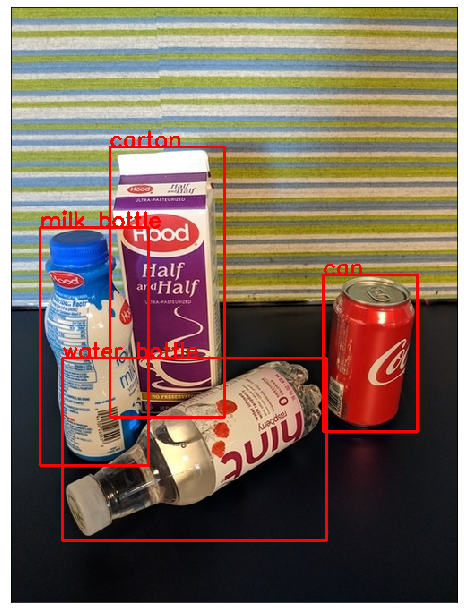

In [7]:
display_bounding_boxes(im_path, boxes, labels, categories)

In [11]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

### Finetuning from a pretrained model
Let’s suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. 

In [13]:
def get_pretrained_model():
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # replace the classifier with a new one, that has num_classes which is user-defined
    num_classes = 5  # 5 class (can, carton, milk_bottle, water_bottle) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

### Putting it all together

Let’s now write the main function which performs the training and the validation:

In [14]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# our dataset has two classes only - background and person
num_classes = 5

# use our dataset and defined transformations
dataset = FridgeObjectsDataset(path, get_transform(train=True))
dataset_test = FridgeObjectsDataset(path, get_transform(train=False))
categories = dataset.category_names

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
)

In [15]:
# get the model using our helper function
model = get_pretrained_model()

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [16]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/39]  eta: 0:00:58  lr: 0.000136  loss: 2.3153 (2.3153)  loss_classifier: 1.9624 (1.9624)  loss_box_reg: 0.3319 (0.3319)  loss_objectness: 0.0068 (0.0068)  loss_rpn_box_reg: 0.0142 (0.0142)  time: 1.4998  data: 0.3172  max mem: 2924
Epoch: [0]  [10/39]  eta: 0:00:10  lr: 0.001451  loss: 1.2178 (1.3016)  loss_classifier: 0.8999 (1.0556)  loss_box_reg: 0.2322 (0.2337)  loss_objectness: 0.0011 (0.0032)  loss_rpn_box_reg: 0.0104 (0.0090)  time: 0.3483  data: 0.0362  max mem: 3534
Epoch: [0]  [20/39]  eta: 0:00:05  lr: 0.002765  loss: 0.6479 (0.9505)  loss_classifier: 0.4026 (0.7133)  loss_box_reg: 0.2031 (0.2238)  loss_objectness: 0.0021 (0.0044)  loss_rpn_box_reg: 0.0071 (0.0090)  time: 0.2239  data: 0.0087  max mem: 3534
Epoch: [0]  [30/39]  eta: 0:00:02  lr: 0.004080  loss: 0.4887 (0.7811)  loss_classifier: 0.2530 (0.5488)  loss_box_reg: 0.2017 (0.2172)  loss_objectness: 0.0037 (0.0055)  loss_rpn_box_reg: 0.0086 (0.0095)  time: 0.2217  data: 0.0102  max mem: 3534
Epoch: [

Epoch: [3]  [ 0/39]  eta: 0:00:21  lr: 0.000500  loss: 0.0948 (0.0948)  loss_classifier: 0.0385 (0.0385)  loss_box_reg: 0.0464 (0.0464)  loss_objectness: 0.0052 (0.0052)  loss_rpn_box_reg: 0.0048 (0.0048)  time: 0.5604  data: 0.2875  max mem: 3541
Epoch: [3]  [10/39]  eta: 0:00:07  lr: 0.000500  loss: 0.0624 (0.0662)  loss_classifier: 0.0286 (0.0330)  loss_box_reg: 0.0253 (0.0252)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0075 (0.0073)  time: 0.2483  data: 0.0356  max mem: 3541
Epoch: [3]  [20/39]  eta: 0:00:04  lr: 0.000500  loss: 0.0608 (0.0644)  loss_classifier: 0.0299 (0.0351)  loss_box_reg: 0.0217 (0.0219)  loss_objectness: 0.0001 (0.0006)  loss_rpn_box_reg: 0.0066 (0.0069)  time: 0.2257  data: 0.0106  max mem: 3541
Epoch: [3]  [30/39]  eta: 0:00:02  lr: 0.000500  loss: 0.0523 (0.0623)  loss_classifier: 0.0310 (0.0336)  loss_box_reg: 0.0142 (0.0208)  loss_objectness: 0.0001 (0.0010)  loss_rpn_box_reg: 0.0066 (0.0069)  time: 0.2256  data: 0.0099  max mem: 3541
Epoch: [

Epoch: [6]  [ 0/39]  eta: 0:00:21  lr: 0.000050  loss: 0.0421 (0.0421)  loss_classifier: 0.0248 (0.0248)  loss_box_reg: 0.0125 (0.0125)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 0.5391  data: 0.2583  max mem: 3542
Epoch: [6]  [10/39]  eta: 0:00:07  lr: 0.000050  loss: 0.0421 (0.0483)  loss_classifier: 0.0277 (0.0290)  loss_box_reg: 0.0125 (0.0139)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0045 (0.0052)  time: 0.2611  data: 0.0350  max mem: 3542
Epoch: [6]  [20/39]  eta: 0:00:04  lr: 0.000050  loss: 0.0409 (0.0469)  loss_classifier: 0.0273 (0.0282)  loss_box_reg: 0.0122 (0.0130)  loss_objectness: 0.0002 (0.0004)  loss_rpn_box_reg: 0.0047 (0.0055)  time: 0.2265  data: 0.0110  max mem: 3542
Epoch: [6]  [30/39]  eta: 0:00:02  lr: 0.000050  loss: 0.0419 (0.0467)  loss_classifier: 0.0264 (0.0277)  loss_box_reg: 0.0123 (0.0135)  loss_objectness: 0.0001 (0.0004)  loss_rpn_box_reg: 0.0047 (0.0051)  time: 0.2216  data: 0.0091  max mem: 3544
Epoch: [

Epoch: [9]  [ 0/39]  eta: 0:00:20  lr: 0.000005  loss: 0.0406 (0.0406)  loss_classifier: 0.0245 (0.0245)  loss_box_reg: 0.0108 (0.0108)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0053 (0.0053)  time: 0.5244  data: 0.3117  max mem: 3544
Epoch: [9]  [10/39]  eta: 0:00:06  lr: 0.000005  loss: 0.0445 (0.0463)  loss_classifier: 0.0296 (0.0295)  loss_box_reg: 0.0123 (0.0119)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0048 (0.0049)  time: 0.2325  data: 0.0341  max mem: 3544
Epoch: [9]  [20/39]  eta: 0:00:04  lr: 0.000005  loss: 0.0413 (0.0445)  loss_classifier: 0.0237 (0.0275)  loss_box_reg: 0.0108 (0.0116)  loss_objectness: 0.0001 (0.0005)  loss_rpn_box_reg: 0.0048 (0.0049)  time: 0.2112  data: 0.0079  max mem: 3544
Epoch: [9]  [30/39]  eta: 0:00:02  lr: 0.000005  loss: 0.0385 (0.0451)  loss_classifier: 0.0236 (0.0274)  loss_box_reg: 0.0108 (0.0123)  loss_objectness: 0.0001 (0.0005)  loss_rpn_box_reg: 0.0051 (0.0049)  time: 0.2167  data: 0.0091  max mem: 3544
Epoch: [

### Inference

In [17]:
# select image
im_path = dataset_test.dataset.root/'images'/dataset_test.dataset.ims[randrange(120)]
im = Image.open(im_path)

# Defing PyTorch Transform
transform = transforms.Compose([transforms.ToTensor()])

# Apply the transform to the image
im = transform(im).cuda()

In [18]:
# put the model in evaluation mode
model.eval()

with torch.no_grad():
    start = time.time()
    pred = model([im])
    print(f"Time spend: {time.time() - start}")

Time spend: 0.044443607330322266


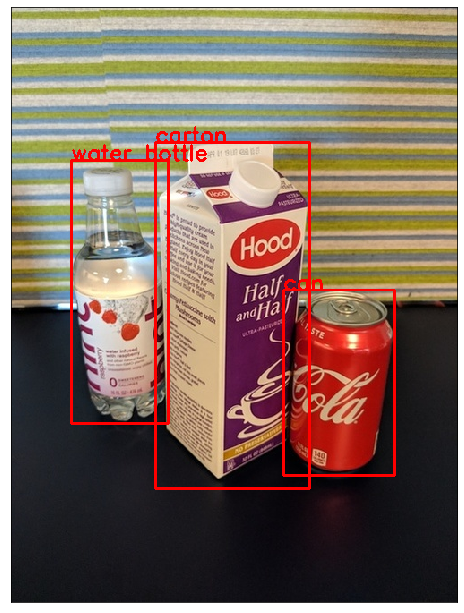

In [19]:
pred_labels, pred_boxes = get_bounding_boxes(pred)
display_bounding_boxes(im_path, pred_boxes, pred_labels, categories)